In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [49]:
# Read sample
df = pd.read_csv("sample_submission.csv", index_col = 'id')

In [50]:
# print smaple data
df.head()

,pressure
id,
1,0
2,0
3,0
4,0
5,0


In [51]:
# Read training data
df2 = pd.read_csv("train.csv", index_col = 'id')

In [52]:
# print training data
df2.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987


In [53]:
# Read testing data
df3 = pd.read_csv("test.csv", index_col = 'id')

In [54]:
# print testing data
df3.head()

,breath_id,R,C,time_step,u_in,u_out
id,,,,,,
1,0,5,20,0.000000,0.000000,0
2,0,5,20,0.031904,7.515046,0
3,0,5,20,0.063827,14.651675,0
4,0,5,20,0.095751,21.230610,0
5,0,5,20,0.127644,26.320956,0


In [55]:
# Check for nulls in training data
df2.isna().sum()

breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [56]:
# Check for nulls in testing data
df3.isna().sum()

breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x2d00989f1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x2d010608550>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d009892580>,
 'medians': [<matplotlib.lines.Line2D at 0x2d010608c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x2d010608f10>,
 'means': []}

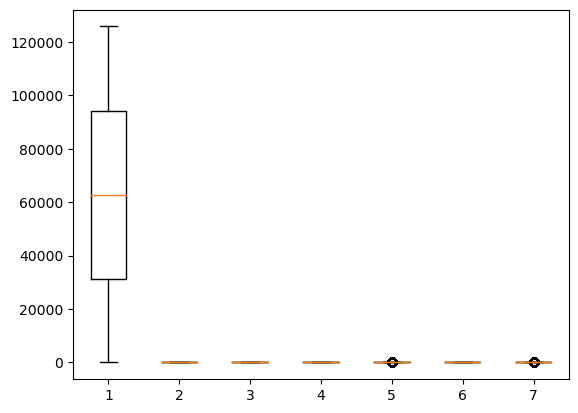

In [57]:
# Check for outliers in training data
plt.boxplot(df2)

{'whiskers': [<matplotlib.lines.Line2D at 0x2d0166e4f10>,
 'caps': [<matplotlib.lines.Line2D at 0x2d0165744f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d0166e4c40>,
 'medians': [<matplotlib.lines.Line2D at 0x2d016574a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x2d016574d60>,
 'means': []}

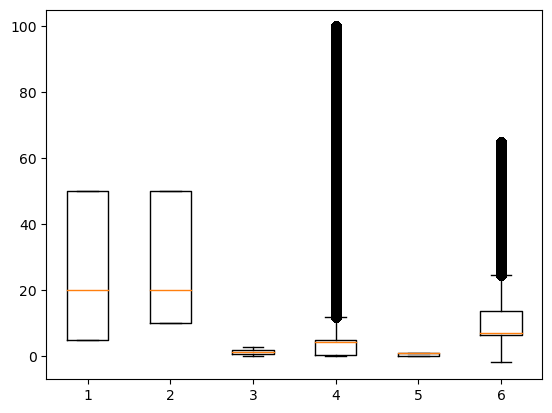

In [58]:
plt.boxplot(df2.drop('breath_id', axis = 1))

In [59]:
quartile1 = df2['u_in'].quantile(0.25)
quartile3 = df2['u_in'].quantile(0.75)
iqr = quartile3 - quartile1
upper_limit = quartile3 + 1.5 * iqr
lower_limit = quartile1 - 1.5 * iqr
df2.dropna(subset = ['u_in'], thresh = lower_limit, inplace = True)
df2.drop(df2[df2['u_in'] > upper_limit].index, inplace = True)

In [60]:
quartile1 = df2['pressure'].quantile(0.25)
quartile3 = df2['pressure'].quantile(0.75)
iqr = quartile3 - quartile1
upper_limit = quartile3 + 1.5 * iqr
lower_limit = quartile1 - 1.5 * iqr
df2.dropna(subset = ['pressure'], thresh = lower_limit, inplace = True)
df2.drop(df2[df2['pressure'] > upper_limit].index, inplace = True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2d016634f40>,
 'caps': [<matplotlib.lines.Line2D at 0x2d016644520>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d016634c70>,
 'medians': [<matplotlib.lines.Line2D at 0x2d016644ac0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2d016644d90>,
 'means': []}

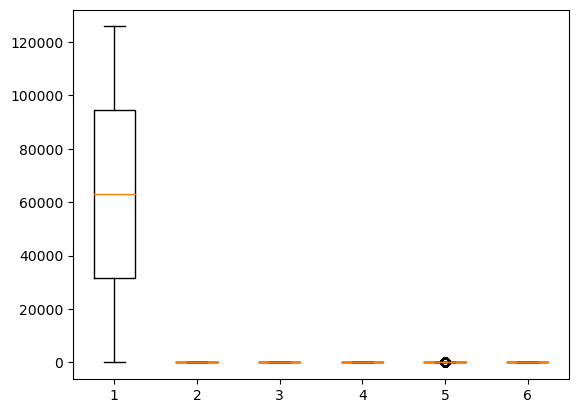

In [61]:
# Check for outliers in testing data
plt.boxplot(df3)

In [62]:
# Check for duplicates in training data
df2.duplicated().sum()

0

In [63]:
# Check for duplicates in testing data
df3.duplicated().sum()

0

In [64]:
# Describtion for training data
df2.describe()

,breath_id,R,C,time_step,u_in,u_out,pressure
count,4.422496e+06,4.422496e+06,4.422496e+06,4.422496e+06,4.422496e+06,4.422496e+06,4.422496e+06
mean,6.289155e+04,2.751340e+01,2.606659e+01,1.578327e+00,3.070310e+00,8.153441e-01,7.251134e+00
std,3.632755e+04,1.959656e+01,1.716754e+01,7.008444e-01,2.408834e+00,3.880182e-01,2.182174e+00
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,3.141400e+04,5.000000e+00,1.000000e+01,1.171209e+00,0.000000e+00,1.000000e+00,6.189002e+00
50%,6.290300e+04,2.000000e+01,2.000000e+01,1.658482e+00,3.785219e+00,1.000000e+00,6.610815e+00
75%,9.432600e+04,5.000000e+01,5.000000e+01,2.142727e+00,4.889413e+00,1.000000e+00,7.454441e+00
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.186921e+01,1.000000e+00,1.532828e+01


In [65]:
# Describtion for testing data
df3.describe()

,breath_id,R,C,time_step,u_in,u_out
count,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06
mean,6.292796e+04,2.710785e+01,2.607038e+01,1.307083e+00,7.338098e+00,6.203864e-01
std,3.624924e+04,1.954281e+01,1.717103e+01,7.658902e-01,1.350955e+01,4.852908e-01
min,0.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.153050e+04,5.000000e+00,1.000000e+01,6.428454e-01,4.096735e-01,0.000000e+00
50%,6.305750e+04,2.000000e+01,2.000000e+01,1.308083e+00,4.377512e+00,1.000000e+00
75%,9.433325e+04,5.000000e+01,5.000000e+01,1.965240e+00,4.983472e+00,1.000000e+00
max,1.257480e+05,5.000000e+01,5.000000e+01,2.935203e+00,1.000000e+02,1.000000e+00


In [66]:
# Number of rows and columns for training data
df2.shape

(4422496, 7)

In [67]:
# Number of rows and columns for testing data
df3.shape

(4024000, 6)

In [68]:
# Check for low correclations because they will be neglected due to low effect and Accelerate processing time in traning data
df2.corr()

,breath_id,R,C,time_step,u_in,u_out,pressure
breath_id,1.000000,0.001463,0.007595,-0.002156,0.000185,-0.002502,0.001275
R,0.001463,1.000000,-0.095267,-0.069138,-0.066900,-0.065709,-0.009198
C,0.007595,-0.095267,1.000000,0.019623,0.070800,0.024342,0.048237
time_step,-0.002156,-0.069138,0.019623,1.000000,0.256687,0.781887,-0.507433
u_in,0.000185,-0.066900,0.070800,0.256687,1.000000,-0.147894,0.018809
u_out,-0.002502,-0.065709,0.024342,0.781887,-0.147894,1.000000,-0.508822
pressure,0.001275,-0.009198,0.048237,-0.507433,0.018809,-0.508822,1.000000


In [69]:
# Check for low correclations because they will be neglected due to low effect and Accelerate processing time in testing data
df3.corr()

,breath_id,R,C,time_step,u_in,u_out
breath_id,1.000000,0.002983,-0.003115,-0.000188,-0.002039,-0.000135
R,0.002983,1.000000,-0.093566,-0.014633,-0.151597,-0.007784
C,-0.003115,-0.093566,1.000000,0.004931,0.153041,0.003774
time_step,-0.000188,-0.014633,0.004931,1.000000,-0.352357,0.839221
u_in,-0.002039,-0.151597,0.153041,-0.352357,1.000000,-0.417020
u_out,-0.000135,-0.007784,0.003774,0.839221,-0.417020,1.000000


In [70]:
# Check for low correclations because they will be neglected due to low effect and Accelerate processing time in traning data
df2.corr()['pressure'].sort_values(ascending = False)

pressure     1.000000
C            0.048237
u_in         0.018809
breath_id    0.001275
R           -0.009198
time_step   -0.507433
u_out       -0.508822
Name: pressure, dtype: float64

In [71]:
df2['sum'] = df2['time_step'] + df2['u_out']
df2['time_power'] = df2['time_step'] ** 2
df2['multi'] = df2['u_in'] * df2['u_out']

In [72]:
scaler = MinMaxScaler(feature_range = (0, 1))
df2['u_out'] = scaler.fit_transform(df2[['u_out']])
df2['u_out']

id
1          0.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
6035996    1.0
6035997    1.0
6035998    1.0
6035999    1.0
6036000    1.0
Name: u_out, Length: 4422496, dtype: float64

In [73]:
df2['time_step'] = scaler.fit_transform(df2[['time_step']])
df2['time_step']

id
1          0.000000
33         0.370894
34         0.382464
35         0.394109
36         0.405657
             ...   
6035996    0.852707
6035997    0.864064
6035998    0.875451
6035999    0.886801
6036000    0.898129
Name: time_step, Length: 4422496, dtype: float64

In [74]:
df2['sum'] = scaler.fit_transform(df2[['sum']])
df2['sum']

id
1          0.000000
33         0.530678
34         0.539309
35         0.547996
36         0.556611
             ...   
6035996    0.890117
6035997    0.898590
6035998    0.907085
6035999    0.915552
6036000    0.924002
Name: sum, Length: 4422496, dtype: float64

In [75]:
df2['time_power'] = scaler.fit_transform(df2[['time_power']])
df2['time_power']

id
1          0.000000
33         0.137562
34         0.146278
35         0.155322
36         0.164557
             ...   
6035996    0.727109
6035997    0.746606
6035998    0.766414
6035999    0.786415
6036000    0.806635
Name: time_power, Length: 4422496, dtype: float64

In [76]:
df2['multi'] = scaler.fit_transform(df2[['multi']])
df2['multi']

id
1          0.000000
33         0.000000
34         0.000000
35         0.000000
36         0.000000
             ...   
6035996    0.125513
6035997    0.125411
6035998    0.131349
6035999    0.107226
6036000    0.124926
Name: multi, Length: 4422496, dtype: float64

In [77]:
df2.corr()['pressure'].sort_values(ascending = False)

pressure      1.000000
C             0.048237
u_in          0.018809
breath_id     0.001275
R            -0.009198
multi        -0.389951
time_step    -0.507433
u_out        -0.508822
time_power   -0.509121
sum          -0.535420
Name: pressure, dtype: float64

In [78]:
x = df2[['sum', 'time_step', 'u_out', 'time_power', 'multi']]
y = df2[['pressure']]

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [80]:
model = Sequential()
model.add(Dense(100, input_shape=(x_train.shape[1],),activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

In [81]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [82]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 4096, validation_split = 0.2, validation_data = (x_test, y_test))

Epoch 1/10
864/864 [==============================] - 35s 37ms/step - loss: 3.2702 - val_loss: 2.1034
Epoch 2/10
864/864 [==============================] - 32s 37ms/step - loss: 2.1146 - val_loss: 2.1025
Epoch 3/10
864/864 [==============================] - 31s 36ms/step - loss: 2.1151 - val_loss: 2.0998
Epoch 4/10
864/864 [==============================] - 31s 36ms/step - loss: 2.1064 - val_loss: 2.0945
Epoch 5/10
864/864 [==============================] - 31s 36ms/step - loss: 2.1052 - val_loss: 2.0975
Epoch 6/10
864/864 [==============================] - 32s 38ms/step - loss: 2.1038 - val_loss: 2.0900
Epoch 7/10
864/864 [==============================] - 42s 49ms/step - loss: 2.1010 - val_loss: 2.1000
Epoch 8/10
864/864 [==============================] - 41s 47ms/step - loss: 2.0998 - val_loss: 2.0864
Epoch 9/10
864/864 [==============================] - 41s 47ms/step - loss: 2.0963 - val_loss: 2.1356
Epoch 10/10
864/864 [==============================] - 40s 47ms/step - loss: 2.095

In [83]:
loss = model.evaluate(x_test, y_test)

27641/27641 [==============================] - 61s 2ms/step - loss: 2.0973


In [84]:
predictions = model.predict(x_test)

27641/27641 [==============================] - 41s 1ms/step


In [85]:
print("Loss:", loss)
print("Predictions:", predictions)

Loss: 2.0973386764526367
Predictions: [[6.1660814]
 [6.3678656]
 [6.7102   ]
 ...
 [6.7016397]
 [6.8493304]
 [6.7493978]]


In [86]:
r_squared = r2_score(y_test, predictions)
print("R-squared on Test Data:", r_squared)

R-squared on Test Data: 0.5590743237469006


In [87]:
print('MSE:', mean_squared_error(y_test, predictions))
print('MAE:', mean_absolute_error(y_test, predictions))

MSE: 2.09734331296483
MAE: 0.9452434867345069


In [88]:
df3['sum'] = df3['time_step'] + df3['u_out']
df3['time_power'] = df3['time_step'] ** 2
df3['multi'] = df3['u_in'] * df3['u_out']

In [89]:
predictions2 = model.predict(df3[['sum', 'time_step', 'u_out', 'time_power', 'multi']])
predictions2

125750/125750 [==============================] - 205s 2ms/step


array([[ 5.865617],
       [ 7.743886],
       [ 9.240965],
       ...,
       [18.186993],
       [18.2566  ],
       [18.332266]], dtype=float32)

In [90]:
df.drop('pressure', axis = 1, inplace = True)
df['pressure'] = predictions2
df.head()

,pressure
id,
1,5.865617
2,7.743886
3,9.240965
4,9.944887
5,10.365307
